### <b style="color: #0eab81">CNN 이미지 분류</b>

In [1]:
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm

from torchvision.datasets import FashionMNIST
from torchvision import transforms

In [2]:
fashion_mnist_train = FashionMNIST(
    'data/FashionMNIST/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
fashion_mnist_test = FashionMNIST(
    'data/FashionMNIST/',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

In [3]:
batch_size = 128
train_loader = DataLoader(
    fashion_mnist_train,
    batch_size = batch_size,
    shuffle = True
)
test_loader = DataLoader(
    fashion_mnist_test,
    batch_size = batch_size,
    shuffle = False
)

In [4]:
class FlattenLayer(nn.Module):
    def forward(self, x):
        sizes = x.size()
        return x.view(sizes[0], -1)
    
# input data (n, 1, 28, 28)
# Conv2d(in_channel, out_channel, stride)
conv_net = nn.Sequential(
    nn.Conv2d(1, 32, 5),    # 28 - 5 + 1 = 24   => (n, 32, 24, 24)
    nn.MaxPool2d(2),        # 24 / 2            => (n, 32, 12, 12)
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(.25),
    nn.Conv2d(32, 64, 5),   # 12 - 4 = 8        => (n, 64, 8, 8)
    nn.MaxPool2d(2),        # 8 / 2             => (n, 64, 4, 4)
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(.25),
    FlattenLayer()          # 64 * 4 * 4 = 1024 => (n, 1024)
)

# test_input = torch.ones(1, 1, 28, 28)
# conv_output_size = conv_net(test_input).size()[-1]
conv_output_size = 1024

mlp = nn.Sequential(
    nn.Linear(conv_output_size, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(.25),
    nn.Linear(200, 10),
)

net = nn.Sequential(
    conv_net,
    mlp
)

In [5]:
def eval_net(net, data_loader, device='cpu'):
    net.eval()
    
    total_correct, n = 0.0, 0
    bar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, data in bar:
        bar.set_postfix({'eval step': i})
        x, y = (d.to(device) for d in data)
        with torch.no_grad():
            result = net(x)
        _, preds = result.max(1)
        total_correct += (preds == y).float().sum() # float를 쓰는 이유는... 나눠야 해서?
        n += len(x)
        
    return (total_correct / n).item()        

In [6]:
def train_net(
    net,
    train_loader,
    test_loader,
    optimizer_cls = optim.Adam,
    loss_fn = nn.CrossEntropyLoss(),
    n_iter = 10,
    device = 'cpu'
):
    net.to(device)
    optimizer = optimizer_cls(net.parameters())
    
    # losses, train_acc, val_acc = [], [], []
    df_history = pd.DataFrame(columns=['epoch', 'loss', 'train_acc', 'val_acc'])
    for epoch in range(n_iter):
        net.train()
        running_loss = 0.0
        total_correct, n = 0.0, 0
        bar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, data in bar:
            bar.set_postfix({'train epoch': epoch + 1})
            optimizer.zero_grad()
            
            x, y = (d.to(device) for d in data)
            result = net(x)
            loss = loss_fn(result, y)
            loss.backward()
            optimizer.step()
            
            _, preds = result.max(1)
            running_loss += loss.item()
            total_correct += (preds == y).float().sum()
            n += len(x)

        df_history.loc[len(df_history)] = [
            epoch,
            running_loss / i,                   # loss
            (total_correct / n).item(),         # train_acc
            eval_net(net, test_loader, device)  # val_acc
        ]

    return df_history            

In [7]:
df_history = train_net(
    net,
    train_loader, 
    test_loader,
    n_iter = 20,
    device = torch.device('cuda:0')
)

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

<Axes: >

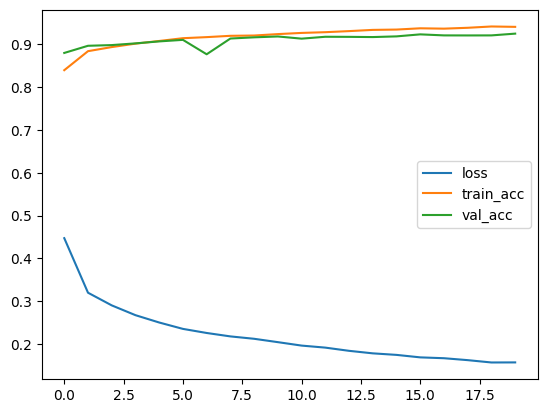

In [8]:
df_history.drop('epoch', axis=1).plot()

### <b style="color: #0eab81">전이학습(타코 & 부리또)</b>

In [16]:
!wget https://github.com/lucidfrontier45/PyTorch-Book/raw/master/data/taco_and_burrito.tar.gz
!mv taco_and_burrito.tar.gz data/taco_and_burrito.tar.gz
!tar -zxvf data/taco_and_burrito.tar.gz -C data/
!rm -rf data/taco_and_burrito.tar.gz

--2023-11-18 00:15:18--  https://github.com/lucidfrontier45/PyTorch-Book/raw/master/data/taco_and_burrito.tar.gz
Resolving github.com (github.com)... 20.200.245.247
Connecting to github.com (github.com)|20.200.245.247|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lucidfrontier45/PyTorch-Book/master/data/taco_and_burrito.tar.gz [following]
--2023-11-18 00:15:18--  https://raw.githubusercontent.com/lucidfrontier45/PyTorch-Book/master/data/taco_and_burrito.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15292798 (15M) [application/octet-stream]
Saving to: ‘taco_and_burrito.tar.gz’

taco_and_burrito.ta 100%[===================>]  14.58M  11.1MB/s    in 1.3s    

2023-11-18 00:15:20 (11.1 M

In [19]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

import os

In [20]:
path_data = 'data/taco_and_burrito/'

train_imgs = ImageFolder(
    os.path.join(path_data, 'train'),
    transform = transforms.Compose([
        transforms.RandomCrop(224),
        transforms.ToTensor()
    ])
)
test_imgs = ImageFolder(
    os.path.join(path_data, 'test'),
    transform = transforms.Compose([
        transforms.RandomCrop(224),
        transforms.ToTensor()
    ])
)

batch_size = 32
train_loader = DataLoader(train_imgs, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_imgs, batch_size=batch_size, shuffle=False)

In [42]:
from torchvision import models
net = models.resnet18(pretrained=True)

/home/k/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/k/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
# 파라미터 고정
for p in net.parameters():
    p.requires_grad = False

# 출력 선형계층 설정
fc_input_dim = net.fc.in_features
net.fc = nn.Linear(fc_input_dim, 2)

In [44]:
def eval_net(net, data_loader, device='cpu'):
    net.eval()
    
    total_correct, n = 0.0, 0
    bar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, data in bar:
        bar.set_postfix({'eval step': i})
        x, y = (d.to(device) for d in data)
        with torch.no_grad():
            result = net(x)
        _, p = result.max(1)
        total_correct += (p == y).float().sum().item()
        n += len(x)
            
    return (total_correct / n)
        

In [45]:
def train_net(
    net,
    train_loader,
    test_loader,
    only_fc = True,
    optimizer_cls = optim.Adam,
    loss_fn = nn.CrossEntropyLoss(),
    n_iter = 10,
    device = 'cpu'
):
    net.to(device)
    optimizer = optimizer_cls(net.fc.parameters() if only_fc else net.parameters())
    
    df_history = pd.DataFrame(columns=['epoch', 'loss', 'train_acc', 'val_acc'])
    for epoch in range(n_iter):
        net.train()
        running_loss, total_correct, n = 0.0, 0.0, 0
        bar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, data in bar:
            bar.set_postfix({'train epoch': epoch + 1})
            optimizer.zero_grad()
            
            x, y = (d.to(device) for d in data)
            result = net(x)
            loss = loss_fn(result, y)
            loss.backward()
            optimizer.step()
            
            _, p = result.max(1)
            running_loss += loss.item()
            total_correct += (p == y).float().sum().item()
            n += len(x)
            
        df_history.loc[len(df_history)] = [
            epoch,
            running_loss / i,
            total_correct / n,
            eval_net(net, test_loader, device)
        ]
        
    return df_history

In [46]:
df_history = train_net(net, train_loader, test_loader, n_iter = 20, device=torch.device('cuda:0'))

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 10.49it/s, eval step=1]


<Axes: >

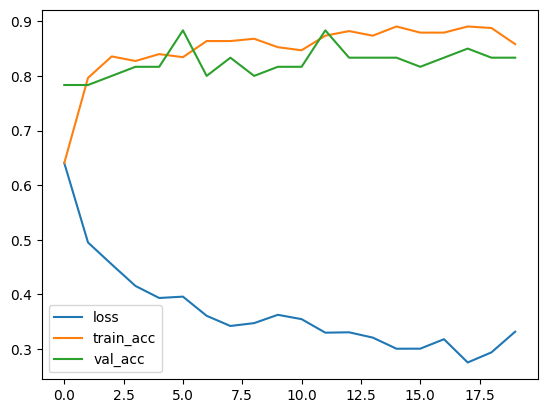

In [47]:
df_history.drop('epoch', axis=1).plot()

In [53]:
# 별도의 CNN 모델 생성하여 훈련 테스트 진행
conv_net = nn.Sequential(
    nn.Conv2d(3, 32, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    FlattenLayer()
)

test_input = torch.ones(1, 3, 224, 224)
conv_output_size = conv_net(test_input).size()[-1]
print(f'conv_output_size: {conv_output_size}')

custom_net = nn.Sequential(
    conv_net,
    nn.Linear(conv_output_size, 2)
)
df_history = train_net(
    net, train_loader, test_loader, n_iter=20, only_fc=False, device=torch.device('cuda:0')
)

conv_output_size: 73728


  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 10.58it/s, eval step=1]


<Axes: >

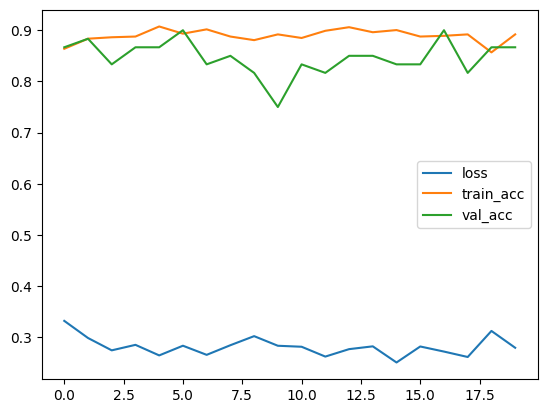

In [54]:
df_history.drop('epoch', axis=1).plot()

### <b style="color: #0eab81">해상도 향상</b>

In [55]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar -zxvf lfw-deepfunneled.tgz
!mkdir lfw-deepfunneled/train
!mkdir lfw-deepfunneled/test
!mv lfw-deepfunneled/[A-W]* lfw-deepfunneled/train
!mv lfw-deepfunneled/[X-Z]* lfw-deepfunneled/test
!mv lfw-deepfunneled data/

--2023-11-18 23:49:13--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz’

lfw-deepfunneled.tg 100%[===================>] 103.72M   284KB/s    in 6m 34s  

2023-11-18 23:55:48 (270 KB/s) - ‘lfw-deepfunneled.tgz’ saved [108761145/108761145]

lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg
lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg
lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg
lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg
lfw-deepfunneled/Aaron_Patterson/Aaron_Patterson_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0004.jpg
l

In [58]:
class DownSizedPairImageFolder(ImageFolder):
    def __init__(
        self,
        root,
        transform = None,
        large_size = 128,
        small_size = 32,
        **kwds
    ):
        super().__init__(root, transform = transform, **kwds)
        self.large_resizer = transforms.Resize(large_size)
        self.small_resizer = transforms.Resize(small_size)
        
    def __getitem__(self, index):
        path, _ = self.imgs[index]
        img = self.loader(path)
        large_img = self.large_resizer(img)
        small_img = self.small_resizer(img)
        
        if self.transform is not None:
            large_img = self.transform(large_img)
            small_img = self.transform(small_img)
            
        return small_img, large_img

In [59]:
train_data = DownSizedPairImageFolder(
    'data/lfw-deepfunneled/train/',
    transform=transforms.ToTensor(),
)
test_data = DownSizedPairImageFolder(
    'data/lfw-deepfunneled/test/',
    transform=transforms.ToTensor(),
)
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=12)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=12)

In [108]:
# CONV RESULT = (W - K + 1) / S + 2 * P
# CONV TRANS RESULT = W * S - (S - 1) + (K - 1) - (2 * P) => W * S - S + 1 + K - 1 - 2P => W*S - S + K - 2P => (W-1)*S + K - 2P
# input = (n, 3, 32, 32)
net = nn.Sequential(
    nn.Conv2d(3, 256, 4, stride=2, padding=1),              # w = (32 - 4) / 2 + 2 = 16
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 4, stride=2, padding=1),            # w = (16 - 4) / 2 + 2 = 8
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),   # w = (8-1) * 2 + 4 - 2 = 16
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),   # w = (16-1) * 2 + 4 - 2 = 32
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),    # w = (32-1) * 2 + 4 - 2 = 64
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),      # w = (64-1) * 2 + 4 - 2 = 128
)
d = torch.device('cuda:0')

In [110]:
torch.cuda.is_available()

True

In [104]:
import math


def psnr(mse, max_v=1.0):
    return 10 * math.log10(max_v**2 / mse)


def eval_net(net, data_loader, device='cpu'):
    net.eval()
    
    total_score = 0.0
    bar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, data in data_loader:
        bar.set_postfix({'eval step': i})
        x, y = (d.to(device) for d in data)
        with torch.no_grad():
            result = net(x)
        total_score += nn.functional.mse_loss(result, y).item()
        
    return total_score / i


def train_net(
    net,
    train_loader,
    test_loader,
    optimizer_cls = optim.Adam,
    loss_fn = nn.MSELoss(),
    n_iter = 10,
    device = 'cpu'
):
    net.to(device)
    optimizer = optimizer_cls(net.parameters())
    
    df_history = pd.DataFrame(columns=['epoch', 'loss', 'train_acc', 'val_acc'])
    for epoch in range(n_iter):
        net.train()
        running_loss, total_score, n = 0.0, 0.0, 0
        bar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, data in bar:
            bar.set_postfix({'epoch': epoch + 1, 'step': i})
            optimizer.zero_grad()
            x, y = (d.to(device) for d in data)
            result = net(x)
            loss = loss_fn(result, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            total_score += nn.functional.mse_loss(result, y).item()
        
        df_history.loc[len(df_history)] = [
            epoch,
            running_loss / i,
            total_score / i,
            eval_net(net)
        ]
    
    return df_history    

In [105]:
train_net(net, train_loader, test_loader, device=torch.device('cuda:0'))

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
